In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import torch
import gpytorch
from matplotlib import pyplot as plt
import math

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
dfs = pickle.load( open( "dfs.data", "rb" ) )

In [3]:
mx=0
for i in range(len(dfs)):
    if len(dfs[i])>mx:
        mx=i
print(mx)

400


In [4]:
a=dfs[mx].iloc[:,:34]

In [5]:
t=list()
for i in a.columns:
    t.append(a[i].dropna())

In [6]:
x=list()
y=list()
columns=list()
for i in t:
    x.append(np.asarray(i.index))
    y.append(np.asarray(i))
    columns.append(i.name)

In [7]:
missing=list()
for i in range(len(x)):
    if len(x[i])==0:
        missing.append(i)
        
for i in missing:
    del x[i]
    del y[i]
    del columns[i]

In [8]:
x_torch=list()
y_torch=list()
for i in range(len(x)):
    x_torch.append(torch.from_numpy(x[i]).type(torch.FloatTensor))
    y_torch.append(torch.from_numpy(y[i]).type(torch.FloatTensor))

In [60]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=len(x), rank=len(x)-1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)


In [61]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [62]:
train_i_task=list()
for i in range(len(x)):
    train_i_task.append(torch.full_like(x_torch[i], dtype=torch.long, fill_value=i))

In [63]:
full_train_x = torch.cat(x_torch)
full_train_i = torch.cat(train_i_task)
full_train_y = torch.cat(y_torch)

In [64]:
model = MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)

In [65]:
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(500):
    optimizer.zero_grad()
    output = model(full_train_x, full_train_i)
    loss = -mll(output, full_train_y)
    loss.backward()
    print('Iter %d/500 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

Iter 1/500 - Loss: 146.887
Iter 2/500 - Loss: 78.830
Iter 3/500 - Loss: 53.973
Iter 4/500 - Loss: 41.080
Iter 5/500 - Loss: 33.279
Iter 6/500 - Loss: 27.989
Iter 7/500 - Loss: 24.230
Iter 8/500 - Loss: 21.425
Iter 9/500 - Loss: 19.261
Iter 10/500 - Loss: 17.573
Iter 11/500 - Loss: 16.203
Iter 12/500 - Loss: 15.068
Iter 13/500 - Loss: 14.163
Iter 14/500 - Loss: 13.378
Iter 15/500 - Loss: 12.722
Iter 16/500 - Loss: 12.174
Iter 17/500 - Loss: 11.681
Iter 18/500 - Loss: 11.248
Iter 19/500 - Loss: 10.858
Iter 20/500 - Loss: 10.518
Iter 21/500 - Loss: 10.183
Iter 22/500 - Loss: 9.912
Iter 23/500 - Loss: 9.668
Iter 24/500 - Loss: 9.425
Iter 25/500 - Loss: 9.168
Iter 26/500 - Loss: 8.984
Iter 27/500 - Loss: 8.805
Iter 28/500 - Loss: 8.657
Iter 29/500 - Loss: 8.512
Iter 30/500 - Loss: 8.406
Iter 31/500 - Loss: 8.254
Iter 32/500 - Loss: 8.161
Iter 33/500 - Loss: 8.064
Iter 34/500 - Loss: 7.942
Iter 35/500 - Loss: 7.876
Iter 36/500 - Loss: 7.803
Iter 37/500 - Loss: 7.724
Iter 38/500 - Loss: 7.649

Iter 308/500 - Loss: 4.035
Iter 309/500 - Loss: 4.022
Iter 310/500 - Loss: 4.018
Iter 311/500 - Loss: 4.018
Iter 312/500 - Loss: 4.025
Iter 313/500 - Loss: 4.018
Iter 314/500 - Loss: 4.004
Iter 315/500 - Loss: 4.011
Iter 316/500 - Loss: 4.018
Iter 317/500 - Loss: 4.003
Iter 318/500 - Loss: 4.001
Iter 319/500 - Loss: 3.987
Iter 320/500 - Loss: 3.970
Iter 321/500 - Loss: 3.987
Iter 322/500 - Loss: 3.987
Iter 323/500 - Loss: 3.974
Iter 324/500 - Loss: 3.965
Iter 325/500 - Loss: 3.967
Iter 326/500 - Loss: 3.962
Iter 327/500 - Loss: 3.973
Iter 328/500 - Loss: 3.962
Iter 329/500 - Loss: 3.947
Iter 330/500 - Loss: 3.942
Iter 331/500 - Loss: 3.949
Iter 332/500 - Loss: 3.947
Iter 333/500 - Loss: 3.951
Iter 334/500 - Loss: 3.933
Iter 335/500 - Loss: 3.938
Iter 336/500 - Loss: 3.934
Iter 337/500 - Loss: 3.933
Iter 338/500 - Loss: 3.922
Iter 339/500 - Loss: 3.908
Iter 340/500 - Loss: 3.909
Iter 341/500 - Loss: 3.913
Iter 342/500 - Loss: 3.905
Iter 343/500 - Loss: 3.913
Iter 344/500 - Loss: 3.891
I

In [66]:
model.eval()
likelihood.eval()
test_x = torch.linspace(0, len(a), len(a)+1)
test_i_task=list()
for i in range(len(x)):
    test_i_task.append(torch.full_like(test_x, dtype=torch.long, fill_value=i))

observed_pred=list()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for i in range(len(x)):
        observed_pred.append(likelihood(model(test_x, test_i_task[i])))

In [67]:
def ax_plot(ax, train_y, train_x, rand_var, title):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.detach().numpy(), rand_var.mean.detach().numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

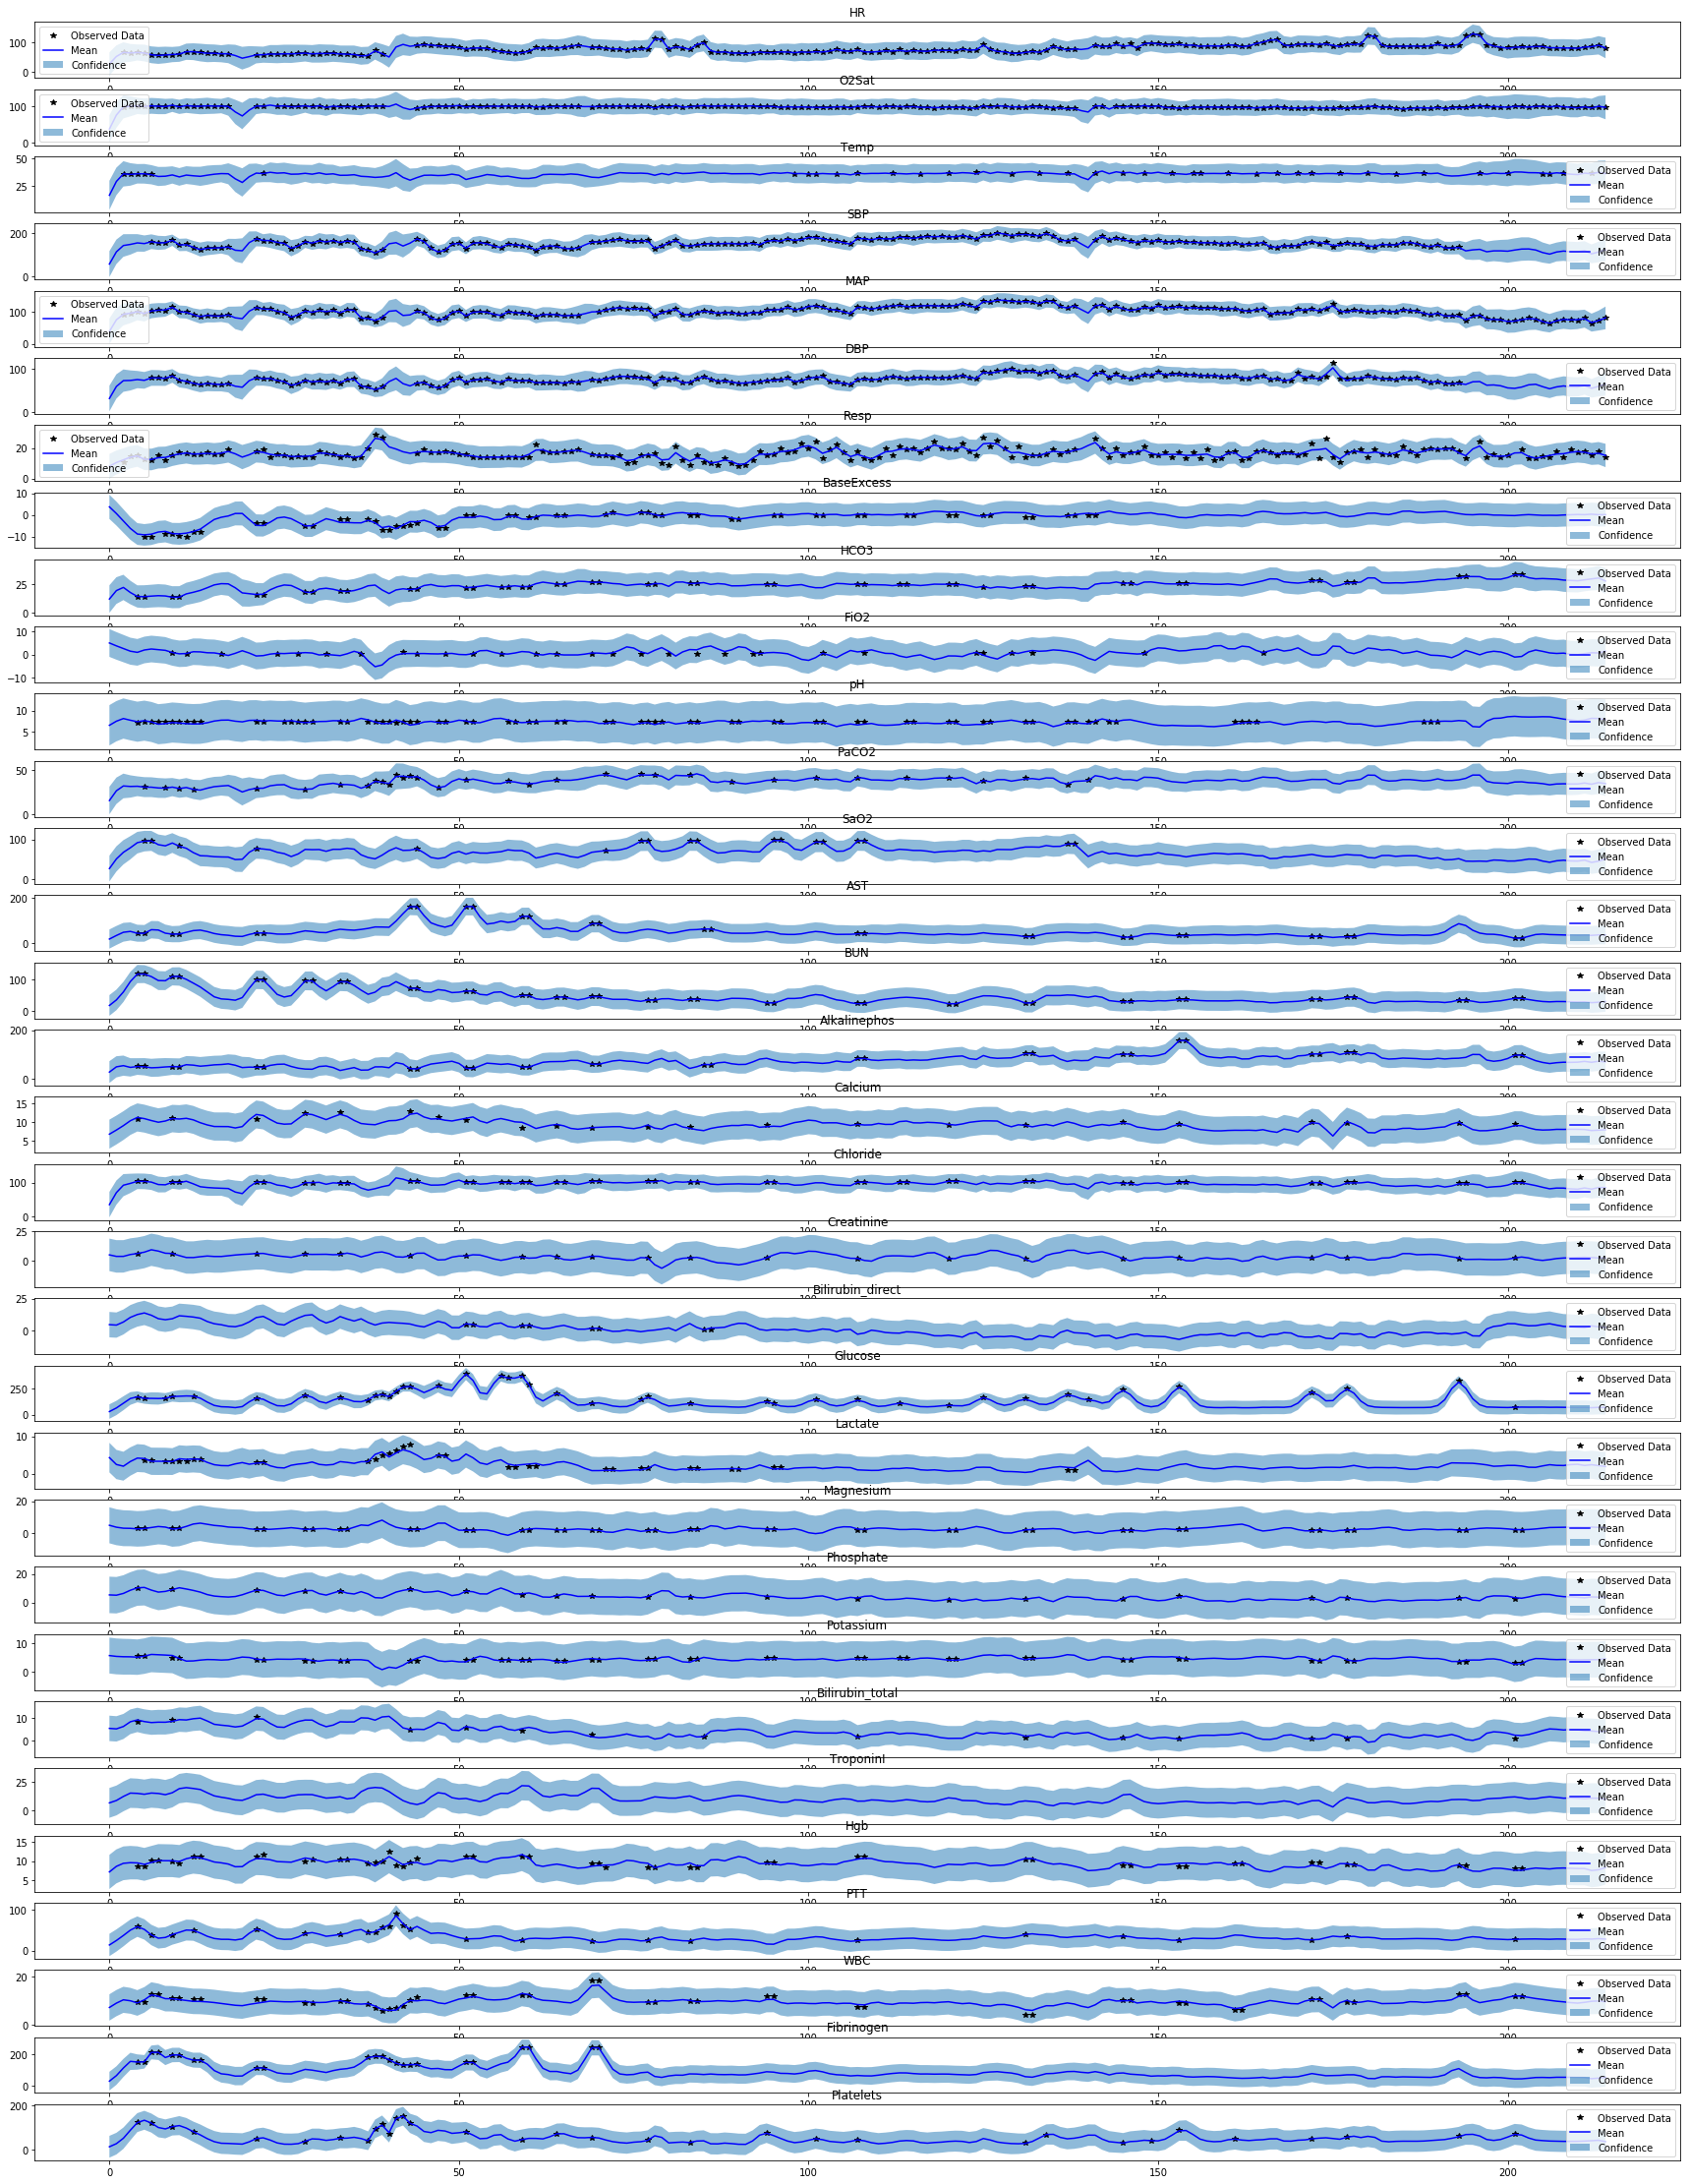

In [68]:
f = plt.figure(figsize=(30,40))
ax_plots=list()
for i in range(len(x)):
    ax_plots.append(plt.subplot(len(x),1,i+1))
for i in range(len(x)):
    ax_plot(ax_plots[i], y_torch[i], x_torch[i], observed_pred[i], columns[i])

In [72]:
 np.hstack([y_torch[0], observed_pred[0]])

array([65.0, 64.0, 65.0, 64.0, 58.0, 55.0, 57.0, 58.0, 60.0, 68.0, 68.0,
       66.0, 62.0, 63.0, 61.0, 61.0, 57.0, 58.0, 59.0, 59.0, 60.0, 61.0,
       62.0, 63.0, 61.0, 61.0, 63.0, 62.0, 61.0, 60.0, 58.0, 55.0, 53.0,
       72.0, 60.0, 90.0, 92.0, 91.0, 89.0, 86.0, 86.0, 82.0, 78.0, 81.0,
       81.0, 80.0, 72.0, 69.0, 66.0, 64.0, 66.0, 69.0, 82.0, 79.0, 82.0,
       80.0, 84.0, 86.0, 90.0, 82.0, 83.0, 79.0, 78.0, 76.0, 74.0, 75.5,
       80.0, 76.0, 114.0, 109.0, 76.0, 86.0, 81.0, 77.0, 90.5, 101.0,
       68.0, 68.0, 66.0, 64.0, 63.0, 62.0, 64.0, 68.0, 65.0, 65.0, 68.0,
       67.0, 64.0, 68.0, 65.5, 69.0, 67.0, 70.0, 75.0, 71.0, 69.0, 75.0,
       66.0, 68.0, 67.0, 72.0, 68.0, 75.0, 68.0, 73.0, 69.0, 69.0, 73.0,
       72.0, 72.0, 71.0, 76.0, 74.0, 73.0, 93.0, 75.0, 70.0, 67.0, 63.0,
       63.0, 67.0, 69.0, 67.0, 73.0, 88.0, 79.0, 76.0, 78.0, 90.0, 85.0,
       85.0, 95.0, 85.0, 95.0, 79.0, 98.0, 96.0, 95.0, 92.0, 92.0, 95.0,
       90.0, 91.0, 86.0, 88.0, 88.0, 87.0, 91.0, 89.0,

In [84]:
len(y_torch[0])

203

In [76]:
torch.cat((y_torch[0], observed_pred[0]), 0)

TypeError: expected Tensor as element 1 in argument 0, but got MultivariateNormal